In [64]:
# 导包
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

def plot_time(sig, fs):
    #绘制时域图
    time = np.arange(0, len(sig)) * (1.0 / fs)
    plt.figure(figsize=(20, 5))
    plt.plot(time, sig)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')#振幅
    plt.grid()

def plot_freq(sig, sample_rate, nfft=512):
    #绘制频域图
    freqs = np.linspace(0, sample_rate/2, nfft//2 + 1)
    xf = np.fft.rfft(sig, nfft) / nfft
    xfp = 20 * np.log10(np.clip(np.abs(xf), 1e-20, 1e100))#强度
    plt.figure(figsize=(20, 5))
    plt.plot(freqs, xfp)
    plt.xlabel('Freq(hz)')
    plt.ylabel('dB')#强度
    plt.grid()
    

def plot_spectrogram(spec, ylabel = 'ylabel'):
    #绘制二维数组
    fig = plt.figure(figsize=(20, 5))
    heatmap = plt.pcolor(spec)
    fig.colorbar(mappable=heatmap)
    plt.xlabel('Time(s)')
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()


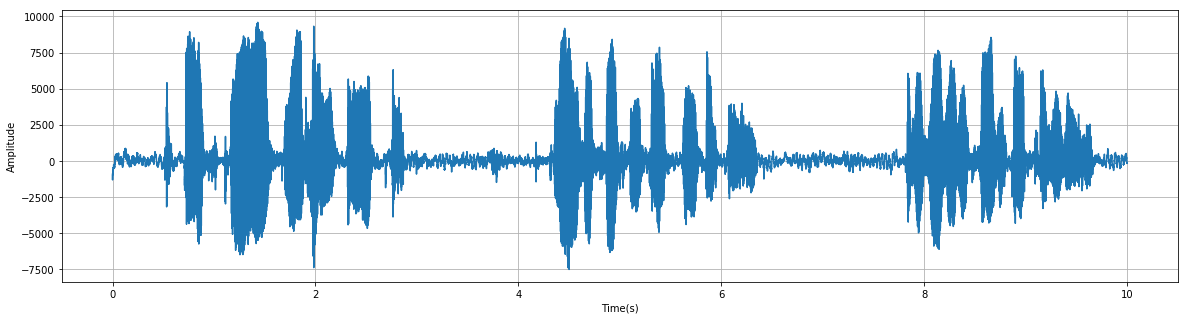

In [45]:
wav_file = 'OSR_us_000_0010_8k.wav'
fs, sig = wavfile.read(wav_file)
#fs是wav文件的采样率，signal是wav文件的内容，filename是要读取的音频文件的路径
sig = sig[0: int(10 * fs)]
# 保留前10s数据
plot_time(sig, fs)

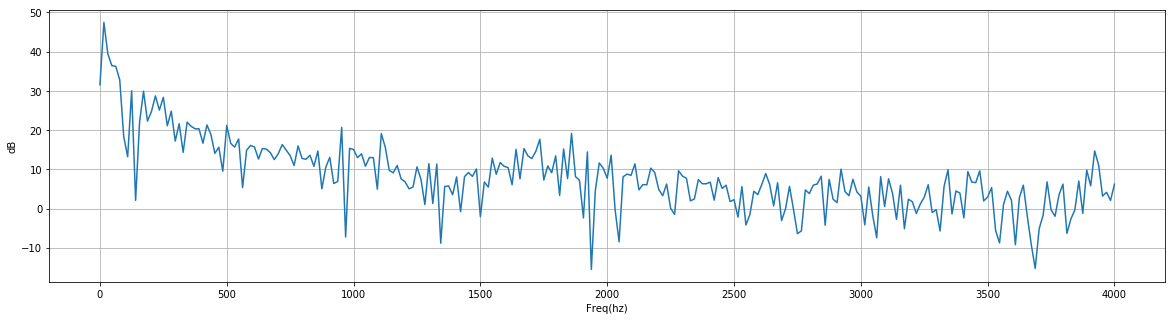

In [46]:
plot_freq(sig, fs) 

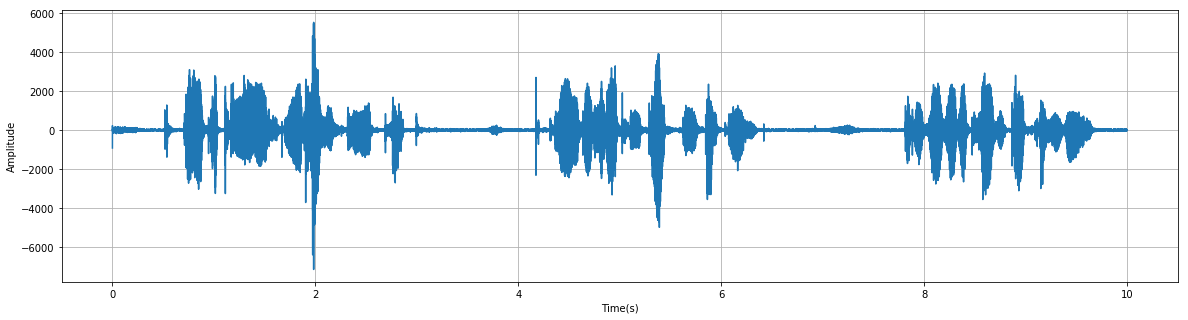

In [47]:
pre_emphasis = 0.97
sig = np.append(sig[0], sig[1:] - pre_emphasis * sig[:-1])
plot_time(sig, fs)

(80000,) 8000


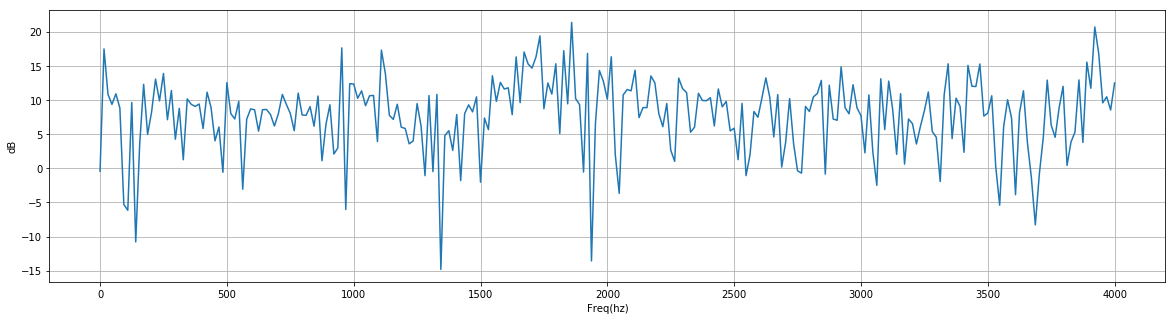

In [50]:
plot_freq(sig, fs) 
print(sig.shape,fs)

In [17]:
def framing(frame_len_s, frame_shift_s, fs, sig):
    """
    分帧，主要是计算对应下标
    :param frame_len_s: 帧长，s
    :param frame_shift_s: 帧移，s
    :param fs:  采样率，hz
    :param sig: 信号
    :return: 二维list，一个元素为一帧信号
    """
    sig_n = len(sig)
    frame_len_n, frame_shift_n = int(round(fs * frame_len_s)), int(round(fs * frame_shift_s))
    num_frame = int(np.ceil(float(sig_n - frame_len_n) / frame_shift_n) + 1)
    pad_num = frame_shift_n * (num_frame - 1) + frame_len_n - sig_n   # 待补0的个数
    pad_zero = np.zeros(int(pad_num))    # 补0
    pad_sig = np.append(sig, pad_zero)
    
    # 计算下标
    # 每个帧的内部下标
    frame_inner_index = np.arange(0, frame_len_n)
    # 分帧后的信号每个帧的起始下标
    frame_index = np.arange(0, num_frame) * frame_shift_n
    
    # 复制每个帧的内部下标，信号有多少帧，就复制多少个，在行方向上进行复制
    frame_inner_index_extend = np.tile(frame_inner_index, (num_frame, 1))
    # 各帧起始下标扩展维度，便于后续相加
    frame_index_extend = np.expand_dims(frame_index, 1)
    # 分帧后各帧的下标，二维数组，一个元素为一帧的下标
    each_frame_index = frame_inner_index_extend + frame_index_extend
    each_frame_index = each_frame_index.astype(np.int, copy=False)
    
    frame_sig = pad_sig[each_frame_index]
    return frame_sig

frame_len_s = 0.025
frame_shift_s = 0.01
frame_sig = framing(frame_len_s, frame_shift_s, fs, sig)

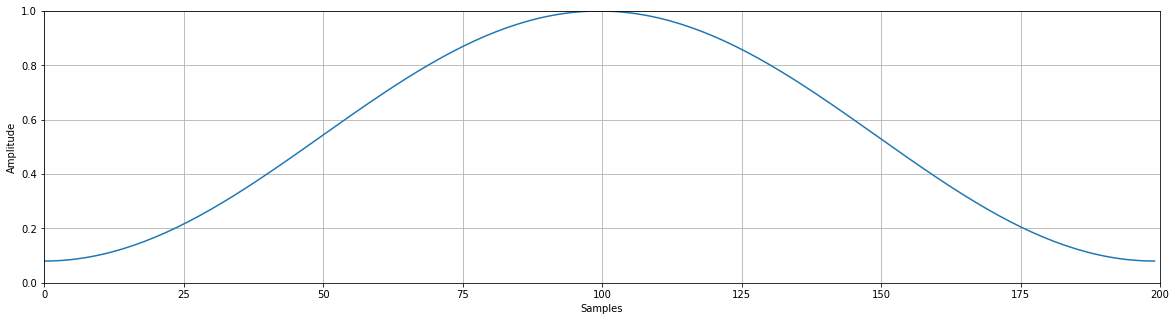

In [18]:
# 加窗
window = np.hamming(int(round(frame_len_s * fs)))
plt.figure(figsize=(20, 5))
plt.plot(window)
plt.grid()
plt.xlim(0, 200)
plt.ylim(0, 1)
plt.xlabel('Samples')
plt.ylabel('Amplitude')
frame_sig *= window

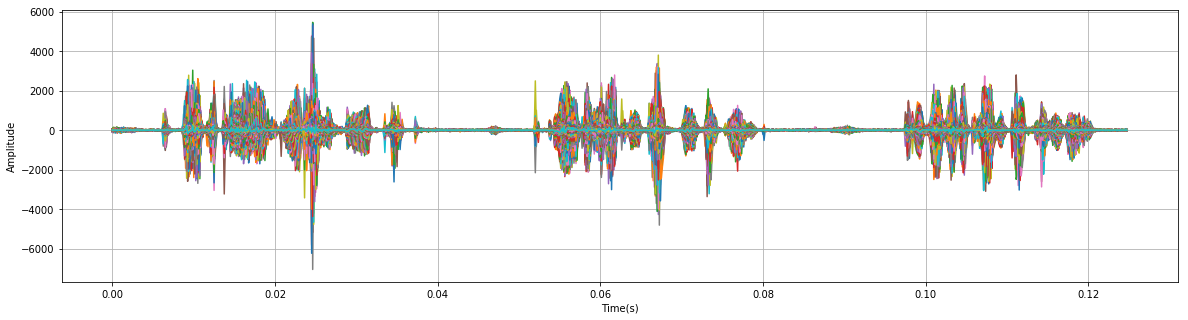

In [23]:
plot_time(frame_sig, fs)

(199800,)


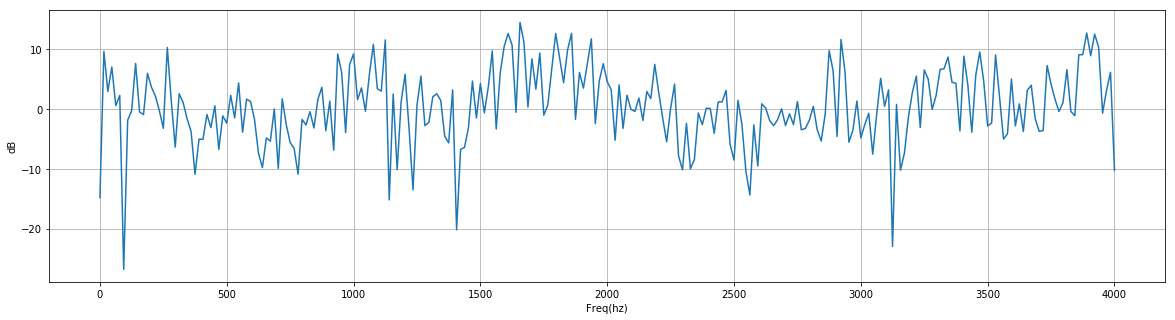

In [58]:
plot_freq(frame_sig.reshape(-1,), fs)
print(frame_sig.reshape(-1,).shape)  #需要先变成一维数据

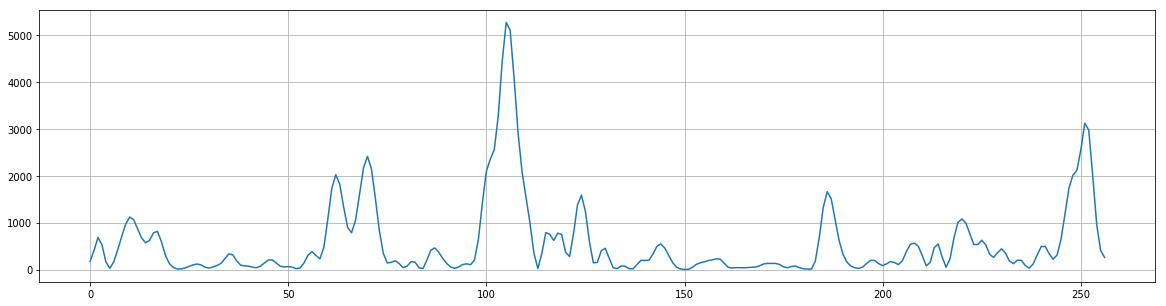

In [60]:
def stft(frame_sig, nfft=512):
    """
    :param frame_sig: 分帧后的信号
    :param nfft: fft点数
    :return: 返回分帧信号的功率谱
    np.fft.fft vs np.fft.rfft
    fft 返回 nfft
    rfft 返回 nfft // 2 + 1，即rfft仅返回有效部分
    """
    frame_spec = np.fft.rfft(frame_sig, nfft)
    # 幅度谱
    frame_mag = np.abs(frame_spec)
    # 功率谱
    frame_pow = (frame_mag ** 2) * 1.0 / nfft
    return frame_pow

nfft = 512
frame_pow = stft(frame_sig, nfft)

plt.figure(figsize=(20, 5))
plt.plot(frame_pow[1])
plt.grid()

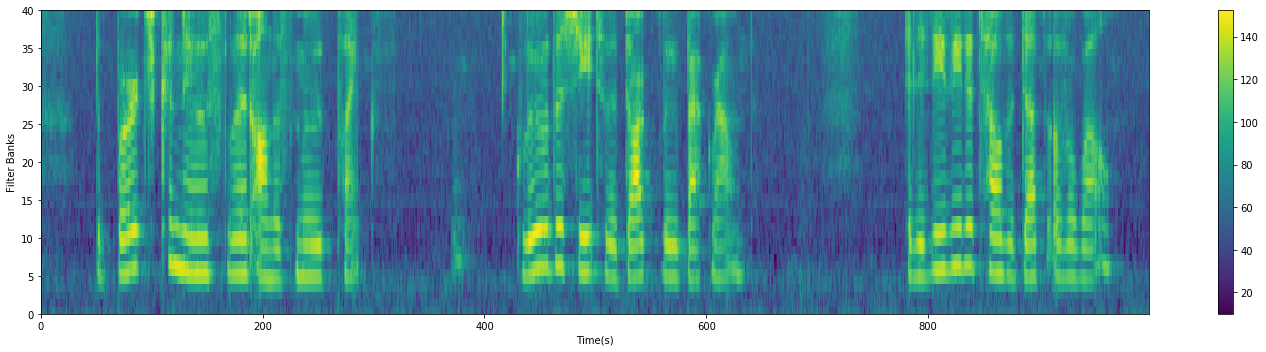

In [65]:
def mel_filter(frame_pow, fs, n_filter, nfft):
    """
    mel 滤波器系数计算
    :param frame_pow: 分帧信号功率谱
    :param fs: 采样率 hz
    :param n_filter: 滤波器个数
    :param nfft: fft点数
    :return: 分帧信号功率谱mel滤波后的值的对数值
    mel = 2595 * log10(1 + f/700)   # 频率到mel值映射
    f = 700 * (10^(m/2595) - 1      # mel值到频率映射
    上述过程本质上是对频率f对数化
    """
    mel_min = 0     # 最低mel值
    mel_max = 2595 * np.log10(1 + fs / 2.0 / 700)   # 最高mel值，最大信号频率为 fs/2
    mel_points = np.linspace(mel_min, mel_max, n_filter + 2)    # n_filter个mel值均匀分布与最低与最高mel值之间
    hz_points = 700 * (10 ** (mel_points / 2595.0) - 1)     # mel值对应回频率点，频率间隔指数化
    filter_edge = np.floor(hz_points * (nfft + 1) / fs)     # 对应到fft的点数比例上
    
    # 求mel滤波器系数
    fbank = np.zeros((n_filter, int(nfft / 2 + 1)))
    for m in range(1, 1 + n_filter):
        f_left = int(filter_edge[m - 1])     # 左边界点
        f_center = int(filter_edge[m])       # 中心点
        f_right = int(filter_edge[m + 1])    # 右边界点
        
        for k in range(f_left, f_center):
            fbank[m - 1, k] = (k - f_left) / (f_center - f_left)
        for k in range(f_center, f_right):
            fbank[m - 1, k] = (f_right - k) / (f_right - f_center)
    
    # mel 滤波
    # [num_frame, nfft/2 + 1] * [nfft/2 + 1, n_filter] = [num_frame, n_filter]
    filter_banks = np.dot(frame_pow, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
    # 取对数
    filter_banks = 20 * np.log10(filter_banks)  # dB
    
    return filter_banks

# mel 滤波
n_filter = 40   # mel滤波器个数
filter_banks = mel_filter(frame_pow, fs, n_filter, nfft)
plot_spectrogram(filter_banks.T, ylabel='Filter Banks')

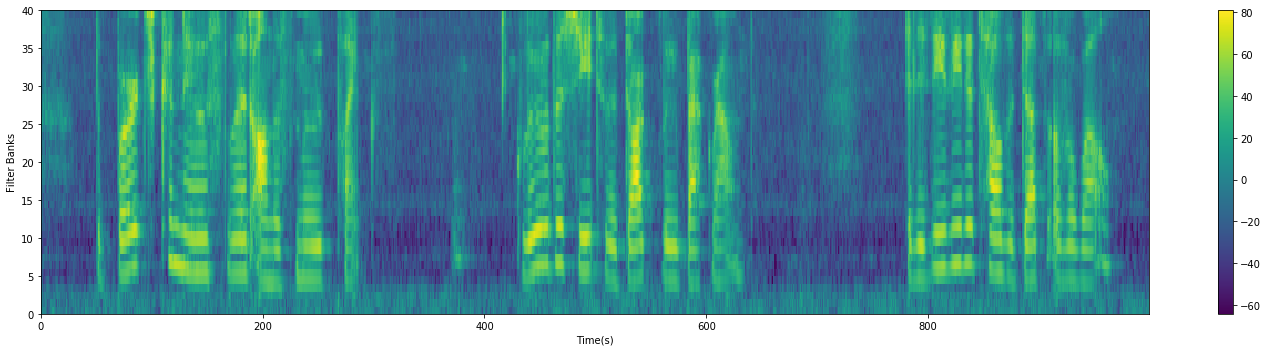

In [66]:
# 去均值
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
plot_spectrogram(filter_banks.T, ylabel='Filter Banks')

#去均值之后的fbank:如下图所示

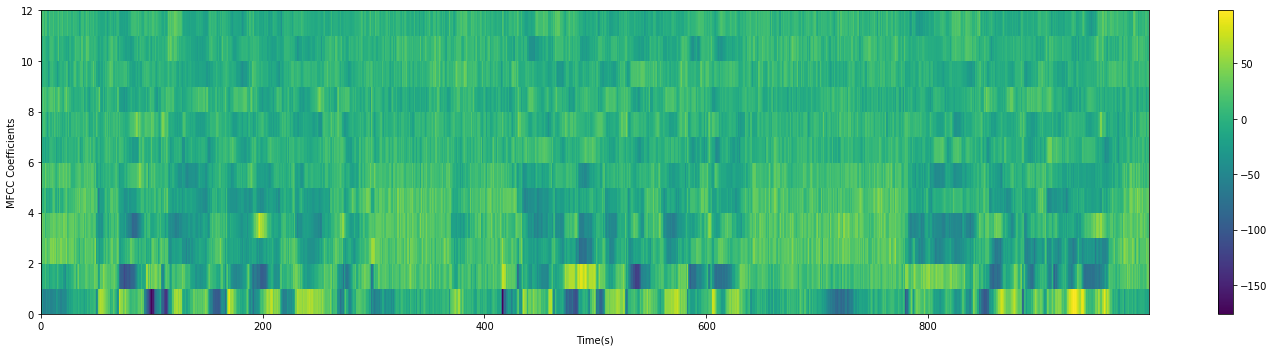

In [67]:
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)]
plot_spectrogram(mfcc.T, 'MFCC Coefficients')

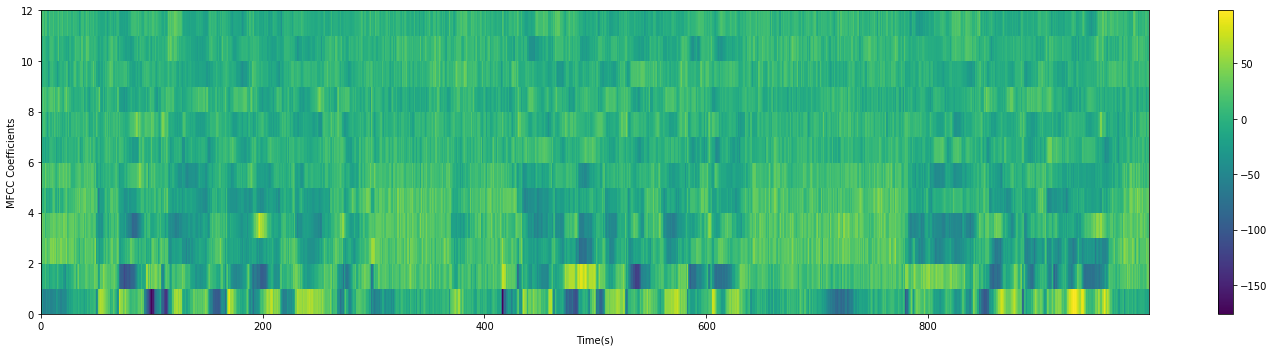

In [68]:
#同样可以对mfcc进行去均值操作。
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
plot_spectrogram(mfcc.T, 'MFCC Coefficients')